In [29]:
using Pkg; Pkg.status()

    Status `~/.julia/environments/v1.3/Project.toml`
  [1537fe66] CALCEPH v1.1.0
  [2e2c70e5] DataFitting v0.1.0
  [a93c6f00] DataFrames v0.21.8
  [31c24e10] Distributions v0.23.12
  [c91e804a] Gadfly v1.3.1
  [7073ff75] IJulia v1.23.2
  [42fd0dbc] IterativeSolvers v0.8.4
  [033835bb] JLD2 v0.2.4
  [2fda8390] LsqFit v0.11.0
  [6e857e4b] MCMCDiagnostics v0.3.0
  [429524aa] Optim v1.2.0
  [c3e4b0f8] Pluto v0.14.9
  [438e738f] PyCall v1.92.1
  [d330b81b] PyPlot v2.9.0
  [2913bbd2] StatsBase v0.33.2
  [f3b207a7] StatsPlots v0.14.14
  [e979afde] TTVFaster v0.0.0 [`../../../work/washington/ttv_project/ttv_ss/TTVFaster`]
  [1986cc42] Unitful v1.4.1
  [6112ee07] UnitfulAstro v1.0.1
  [8bb1440f] DelimitedFiles 
  [37e2e46d] LinearAlgebra 
  [9a3f8284] Random 
  [10745b16] Statistics 


In [39]:
using TTVFaster,LsqFit

In [33]:
sigma,nyear=10.0,30.0
infile = string("FITS/fromEMB/p2_fit",sigma,"s",nyear,"yrs.jld2")
p = jldopen(String(infile),"r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/fromEMB/p2_fit10.0s30.0yrs.jld2 (read-only)
 ├─🔢 chi2
 ├─🔢 best_p2
 ├─🔢 lprob_best_p2
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 └─🔢 sigtt

In [36]:
tt0,tt,ttmodel,sigtt=p["tt0"],p["tt"],p["ttmodel"],p["sigtt"]
nt1,nt2 = p["ntrans"][1],p["ntrans"][2]
best_p2=p["best_p2"]
Nobs = sum([nt1,nt2])
jmax=5
jd1=2.4332825e6
tref=2430000
tol=1e-5
jd2 = nyear*365.25 + jd1
weight = ones(nt1+nt2)./ sigtt.^2 #assigns each data point stat weight d.t. noise = 1/σ^2
println(infile," loaded.")
println("Previous model params: ",best_p2)

FITS/fromEMB/p2_fit10.0s30.0yrs.jld2 loaded.
Previous model params: [2.861853821007559e-6, 224.70077531188355, 3503.765509048137, 0.034328155119923515, 0.006951416154433736, 3.2935957183068157e-6, 365.2564330932285, 3624.4026106116307, 0.040515594087824874, 0.0064489206515410125]


In [53]:
import Main.TTVFaster.ttv_wrapper
p3in,p3out,np3,nphase=10*365.25,13*365.25,50,36
# Now,let's add the 3rd planet:
ntrans = [nt1,nt2,2] #requires at least 2 transits for each planet (even if it doesnt transit)
nplanet = 3
nparam = 15
# Grid of periods to search over:
p3 = 10 .^ range(log10(p3in),stop=log10(p3out),length=np3)
lprob_p3 = zeros(np3)
p3_cur = 11.86*365.25 #jupiter period in days,initial value
param_p3 = zeros(nparam,np3)
lprob_best = -1e100 #global best fit
p3best = zeros(nparam)
niter = 0
for j=1:np3
phase = p3[j]*range(0,stop=1,length=nphase) 
lprob_phase = zeros(nphase)
lprob_p3[j] = -1e100
# Loop over planet 3 phases:
for i=1:nphase 
 # p3 param_names: mass ratio,phase,ecosw,esinw
  param_tmp = [log10(1e-3),phase[i],0.01,0.01] 
  param3 = [best_p2;param_tmp] #concatenate 2 planet model to 3 planet model params
  p3_cur = p3[j] #sets jupiter period to global value
  param1 = param3 .+ 100.0
  while maximum(abs.(param1 .- param3)) > tol #&& niter < 20
    param1 = param3
    fit = curve_fit((tt0,param3) -> ttv_wrapper(tt0,nplanet,ntrans,[param3[1:10];10^param3[11];p3_cur;param3[12:end]],jmax,true),tt0,tt,weight,param3)
    param3 = fit.param
    niter+=1
    # println("init_param: ",param3)
    # println("New Initial chi-square: ",chisquare(tt0,nplanet,ntrans,param3,tt,sigtt,true,p3_cur))
end
  # ttmodel = ttv_wrapper(tt0,nplanet,ntrans,[param3[1:10];10^param3[11];p3_cur;param3[12:end]],jmax,true)
  # lprob_phase[i]= (1 - Nobs/2) * log(sum((tt-ttmodel).^2 ./sigtt.^2))
  # if lprob_phase[i] > lprob_best # check that best fit for period is better than global best fit
  #   lprob_best = lprob_phase[i]
  #   p3best = [fit.param[1:10];10^fit.param[11];p3_cur;fit.param[12:end]]
  # end
  # if lprob_phase[i] > lprob_p3[j] # checks best fit over all phases of jupiter for this particular period
  #   lprob_p3[j] = lprob_phase[i]
  #   param_p3[1:nparam,j] =  [fit.param[1:10];10^fit.param[11];p3_cur;fit.param[12:end]]
  # end
end
println("Period: ",p3[j]," log Prob: ",lprob_p3[j]," Param: ",vec(param_p3[1:nparam,j]))
end
println("Finished 3-planet fit w/ fixed period: ",p3best," in ",niter," iterations")

Period: 3652.5000000000014 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3672.1092973432073 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3691.8238717684926 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3711.644288480399 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3731.5711157179144 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3751.604924770736 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3771.746289995668 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Period: 3791.9957888330796 log Prob: -1.0e100 Param: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

InterruptException: [91mInterruptException:[39m

In [51]:
# curve_fit(model_inplace, xdata, ydata, p0; inplace = true, maxIter=100);
curve_fit((tt0,param3) -> ttv_wrapper(tt0,nplanet,ntrans,[param3[1:10];10^param3[11];p3_cur;param3[12:end]],jmax,true),tt0,tt,weight,param3)

UndefVarError: [91mUndefVarError: param3 not defined[39m

In [1]:
# using PyPlot,JLD2,Statistics,PyCall
# rc("font",family="serif")
# include("CGS.jl")

In [2]:
matplotlib.animation = pyimport("matplotlib.animation")

PyObject <module 'matplotlib.animation' from '/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py'>

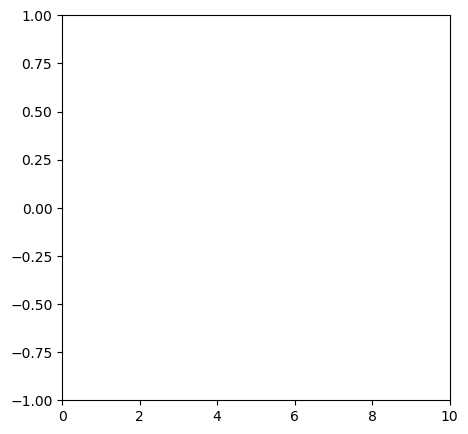

PyObject <matplotlib.animation.FuncAnimation object at 0x13dad2470>

In [3]:
function simData()
    t_max = 10.0
    dt = 0.05
    x = 0.0
    t = -dt

    function it()
        while t < t_max
            x = sin(pi * t)
            t = t + dt
            produce(x, t)
        end
    end

    Task(it)
end

function simPoints()
    task = simData()

    function points(frame_number)
        x, t = consume(task)
        line.set_data(t, x)
        return(line, "")
    end

    points
end

fig = figure(figsize=(5,5))
axis = fig.add_subplot(111)
line = axis.plot([], [], "bo", ms = 10)[1]
axis.set_ylim(-1, 1)
axis.set_xlim(0, 10)

ani = matplotlib.animation.FuncAnimation(fig, simPoints(), blit=false, interval=10, frames=200, repeat=false)

In [5]:
ani.save("test1.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
    
# # Function for creating an embedded video given a filename
# function html_video(filename)
#     open(filename) do f
#         base64_video = base64encode(f)
#         """<video controls src="data:video/x-m4v;base64,$base64_video">"""
#     end
# end

Traceback (most recent call last):
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: UndefVarError: consume not defined
Stacktrace:
 [1] (::var"#points#4"{Task})(::Int64) at ./In[3]:22
 [2] #invokelatest#1(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::typeof(Base.invokelatest), ::Any, ::Any, ::Var

PyCall.PyError: [91mPyError ($(Expr(:escape, :(ccall(#= /Users/bethleelindor/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>[39m
[91mValueError('outfile must be *.htm or *.html')[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 1166, in save[39m
[91m    with writer.saving(self._fig, filename, dpi):[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/contextlib.py", line 112, in __enter__[39m
[91m    return next(self.gen)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 228, in saving[39m
[91m    self.setup(fig, outfile, dpi, *args, **kwargs)[39m
[91m  File "/Users/bethleelindor/.julia/conda/3/lib/python3.7/site-packages/matplotlib/animation.py", line 857, in setup[39m
[91m    raise ValueError("outfile must be *.htm or *.html")[39m


### Simulate obs

In [2]:
include("sim_times.jl")
jd1=2.4332825e6
tref=2430000
tol=1e-5
# @time sim_times(jd1, 30, 30, true)

1.0e-5

In [ ]:
include("ttv_wrapper.jl")

## Fit 2 planets

In [22]:
include("fit_planet2.jl")
@time fit_planet2(jd1,30,30,2430000,1e-5,true)

Loading.... INPUTS/tt_30sEMB30yrs.txt
Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
New initial 2-planet fit: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Finished 2-planet fit: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126] 2
New 2-planet chi-square: 582.8973442491646
  0.925496 seconds (1.24 M allocations: 64.694 MiB)


In [23]:
@time fit_planet2(jd1,30,30,2430000,1e-5,false)

Loading.... INPUTS/tt_30snoEMB30yrs.txt
Initial parameters: [3.0e-6, 224.70077409705425, 3503.768807440609, 0.01, 0.01, 3.0e-6, 365.25642931515705, 3624.4078769599423, 0.01, 0.01]
Initial chi-square: 1116.9958037616166
New initial 2-planet fit: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312]
Finished 2-planet fit: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312] 2
New 2-planet chi-square: 646.8498193209612
  0.055315 seconds (8.27 k allocations: 1.975 MiB)


linear regression of times for each planet as a function of epochs, so find multiples ?

## Fit 3 planets

In [ ]:
include("fit_planet3.jl")
@time fit_planet3("INPUTS/tt_10.0sEMB30.0yrs.txt", jd1, 10, 30, 2430000, 1e-5, 11.8*365.25, 12.2*365.25, 10,36)

In [24]:
include("fit_planet3.jl")
fit_planet3(jd1,30,30,2430000,1e-5,11.8*365.25,12.2*365.25,10,36,true)

Planet 2 fit loaded.
Finished 3-planet fit w/ fixed period: [2.5636449587818454e-6, 224.70077915499394, 3503.765371309062, -8.47766135727757e-5, 0.006696765903281945, 3.04555823363696e-6, 365.2564445366548, 3624.402316415585, 0.014223771433809894, 0.007967444503650058, 0.0008153343308685443, 4309.949999999998, 398.11271966035935, 0.01782379554006557, -0.04071679533979835] in 20 iterations
Finished global 3-planet fit.
New 3-planet chi-square: 109.62309162509258
Maximum: -183.1848736509426 Param: [2.5422216286956403e-6, 224.70078014615882, 3503.76534735665, -0.0026337842281164846, 0.007070111985469569, 3.025608895705259e-6, 365.2564540131243, 3624.402170771069, 0.012059674661027565, 0.00829727159197438, 0.0007712306397113555, 4210.131993226086, 603.9755048375332, 0.016164431567252818, -0.04249204621169487]


15-element Array{Float64,1}:
    2.5422216286956403e-6
  224.70078014615882     
 3503.76534735665        
   -0.0026337842281164846
    0.007070111985469569 
    3.025608895705259e-6 
  365.2564540131243      
 3624.402170771069       
    0.012059674661027565 
    0.00829727159197438  
    0.0007712306397113555
 4210.131993226086       
  603.9755048375332      
    0.016164431567252818 
   -0.04249204621169487  

In [25]:
fit_planet3(jd1,30,30,2430000,1e-5,11.8*365.25,12.2*365.25,10,36,false)

Planet 2 fit loaded.
Finished 3-planet fit w/ fixed period: [3.952659740374452e-6, 224.70077782469306, 3503.7687322283437, -0.06316276127978955, -0.056474200909316374, 2.6701857105107112e-6, 365.2564513292232, 3624.4075023619616, -0.03344929126760719, -0.043254278761422384, 0.0004374762356276606, 4309.949999999998, 1232.4406792403076, -0.0722746772637546, 0.10238680566675712] in 20 iterations
Finished global 3-planet fit.
New 3-planet chi-square: 216.95718382951577
Maximum: -209.8083009567078 Param: [3.9054143218903965e-6, 224.70078008469463, 3503.768675936336, -0.06713129085431972, -0.057465222100601364, 2.6456719043334846e-6, 365.25646164115346, 3624.40734259709, -0.03675516797288188, -0.043738317868158474, 0.00034969118061929096, 4187.244650961268, 1498.0946294769674, -0.1134873127886096, 0.12687238048733113]


15-element Array{Float64,1}:
    3.9054143218903965e-6 
  224.70078008469463      
 3503.768675936336        
   -0.06713129085431972   
   -0.057465222100601364  
    2.6456719043334846e-6 
  365.25646164115346      
 3624.40734259709         
   -0.03675516797288188   
   -0.043738317868158474  
    0.00034969118061929096
 4187.244650961268        
 1498.0946294769674       
   -0.1134873127886096    
    0.12687238048733113   

if we change the linear regression to difference b/w current and first time/period estimate, same $\chi^2$ values for Hpp and Hppp

In [14]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",3,"_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/fromEMB/p3_fit30s30yrs.jld2","r")
@time MCMC(foutput,p[string("best_p",3)],p[string("lprob_best_p",3)],30000,80,3,p["ntrans"][1:3],p["tt0"],p["tt"],p["sigtt"],true,true)

Parameters from fit: [2.5422216286956403e-6, 224.70078014615882, 3503.76534735665, -0.0026337842281164846, 0.007070111985469569, 3.025608895705259e-6, 365.2564540131243, 3624.402170771069, 0.012059674661027565, 0.00829727159197438, 0.0007712306397113555, 4210.131993226086, 603.9755048375332, 0.016164431567252818, -0.04249204621169487]
Maximum log Prob from fit: -183.1848736509426
Step: 232 Walker: 8 Trial Log Prob: 581.9421325158422 Prob: 0.5688380963534208 Frac: 0.34665729121592387
Step: 307 Walker: 20 Trial Log Prob: 592.2992277017046 Prob: 2.3253722301980706 Frac: 0.34330612244897957
Step: 399 Walker: 47 Trial Log Prob: 589.102007529864 Prob: 6.650041610453077 Frac: 0.3418007338413774
Step: 971 Walker: 58 Trial Log Prob: 586.7983306941493 Prob: 0.5641225709022497 Frac: 0.3263025058590229
Number of steps: 1000 Acceptance Rate: 0.326175
Step: 1114 Walker: 62 Trial Log Prob: 592.423840639034 Prob: 0.0383361450205321 Frac: 0.3171830366952318
Step: 1447 Walker: 29 Trial Log Prob: 575.808

([169.40144817812612 169.40144817812612 … 587.271885068746 587.271885068746; 461.35238417096207 461.35238417096207 … 587.1830343615181 592.0702639687793; … ; 308.1155788869501 334.53641105079686 … 593.2521418370658 593.2521418370658; 89.14327711492933 89.14327711492933 … 590.1766462098168 590.1766462098168], [2.682892782118084e-6 2.682892782118084e-6 … 2.5338162325368666e-6 2.5338162325368666e-6; 2.4338066567293965e-6 2.4338066567293965e-6 … 2.625496599535467e-6 2.6896237435583953e-6; … ; 2.572313601936117e-6 2.497413053628608e-6 … 2.3416694101915787e-6 2.3416694101915787e-6; 2.466471761975643e-6 2.466471761975643e-6 … 2.6823605707043844e-6 2.6823605707043844e-6]

[224.7007701289645 224.7007701289645 … 224.7007913866563 224.7007913866563; 224.70077808199323 224.70077808199323 … 224.70078477553702 224.70078156619593; … ; 224.70077168539868 224.70077348161837 … 224.7007768374927 224.7007768374927; 224.70077485287499 224.70077485287499 … 224.70078004487257 224.70078004487257]

[3503.76534

In [16]:
get_vals(30,30,"EMB","p3") #new results

Retrieved masses.
[0.8425190719960819, 1.007486060929999, 236.7495788346493] +/- [0.06590501098325059, 0.04563773915654923, 50.09729854164013]
Retrieved periods.
[224.70078027605965, 365.2564541126595, 4204.494109655528] +/- [4.760203901121633e-6, 1.0727564492812934e-5, 59.80817119970429]
Retrieved eccentricities.
[0.009003743854717496, 0.01493392086511449, 0.04670464983661259] +/- [0.006982018475401733, 0.006460756901152726, 0.026555286607209138]
Retrieved σ_tot.
[40.01570832281971]


([0.8425190719960819, 1.007486060929999, 236.7495788346493], [0.06590501098325059, 0.04563773915654923, 50.09729854164013], [224.70078027605965, 365.2564541126595, 4204.494109655528], [4.760203901121633e-6, 1.0727564492812934e-5, 59.80817119970429], [40.01570832281971])

In [17]:
get_vals(30,30,"noEMB","p3moon")

Retrieved masses.
[0.7846710502401281, 1.0065207391353952, 244.3755395343793] +/- [0.13679758424267405, 0.045678000789704756, 50.1794266129493]
Retrieved periods.
[224.70078000075085, 365.25645261372506, 4218.172284568888] +/- [4.798818833751541e-6, 1.1221499868887634e-5, 61.324221873301624]
Retrieved eccentricities.
[0.008820366782207562, 0.0143431619478587, 0.0394397914007051] +/- [0.006862252476600565, 0.006125242665288864, 0.0247901131694526]
Retrieved σ_tot.
[40.68796455799439]


([0.7846710502401281, 1.0065207391353952, 244.3755395343793], [0.13679758424267405, 0.045678000789704756, 50.1794266129493], [224.70078000075085, 365.25645261372506, 4218.172284568888], [4.798818833751541e-6, 1.1221499868887634e-5, 61.324221873301624], [40.68796455799439])

In [28]:
l=jldopen("FITS/p3_fit10.0s30.0yrs.jld2","r");l["best_p3"]

JLD2.InvalidDataException: [91mJLD2.InvalidDataException()[39m

In [22]:
for i=1:20
println(p3fit["p3"][i],p3fit["lprob_p3"][i]) 
end

3871.649999999999-276.5774874289421
3928.7568520770733-339.62147473138464
3986.706030437296-333.59056720457716
4045.509959396515-327.04507759362735
4105.181246529289-320.68509412175524
4165.732685371933-314.5047926547916
4227.177258165488-307.3752542362572
4289.528138639092-301.58034049349607
4352.798694834437-297.8492546887256
4417.002491971883-296.5415026816816
4482.153295358842-297.47249206867536
4548.265073341053-300.05621302844133
4615.352000297417-303.61150276988235
4683.428459678977-307.58124087445754
4752.509047092726-311.595135307827
4822.608573430924-315.44241474784127
4893.742068046544-319.0227176178231
4965.924781975563-321.9440206445472
5039.17219120681-324.66485808081626
5113.499999999999-327.2475861517312


In [10]:
typeof(p3fit["p3"])

Array{Float64,1}

In [4]:
p3mcmc=jldopen("MCMC/p3_mcmc10.0s30.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/MCMC/p3_mcmc10.0s30.0yrs.jld2 (read-only)
 ├─🔢 par_mcmc
 ├─🔢 lprob_mcmc
 ├─🔢 param
 ├─🔢 nwalkers
 ├─🔢 nsteps
 ├─🔢 accept
 ├─🔢 iburn
 └─🔢 indepsamples

### Fit 3 planets with moon

In [7]:
include("fit_moon.jl")
@time fit_moon("INPUTS/tt_30.0sEMB30.0yrs.txt", jd1, 30, 30, 2430000, 1e-5, 11*365.25, 12*365.25, 10,2,2.2,2.4,10)

Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
Finished 2-planet fit in 2 iterations.
New 2-planet chi-square: 582.8973442491646
Param: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Period: 4017.7500000000005 log Prob: -189.46601221816414 Param: [2.5291201524506193e-6, 224.700781748719, 3503.765315553172, -0.007524154721604066, 0.010310348089924117, 2.9904249311384083e-6, 365.2564682064298, 3624.401973096343, 0.007758608735543599, 0.010430703981311303, 0.0006103586520948597, 4017.7500000000005, 972.8355592397501, -0.002904010437680954, -0.05281346533802197]
Period: 4056.781702757627 log Prob: -187.20238046950385 Param: [2.5281086994377596e-6, 224.70078146708605, 3503.765320065127, -0.006599849

([2.54221325224715e-6, 224.70078014619605, 3503.7653473561827, -0.0026345136279696765, 0.007069730982741328, 3.0256043008594486e-6, 365.25645401372145, 3624.4021707620127, 0.012059105014406485, 0.008297004733231224, 0.0007712456797489318, 4210.127279427517, 4814.116162382293, 0.016166728775144693, -0.04249075208242041], [2.459137568961616e-6, 224.7007799684284, 3503.765353483366, -0.001514266148458868, 0.0022424477277027846, 3.030440781073223e-6, 365.2564531616774, 3624.4021832537937, 0.013008255820559226, 0.00446238274600374, 0.0007827285087471828, 4218.096902213769, 4855.056186383757, 0.01491875009236496, -0.036196969357057865, -0.00010047923994553857, 0.00015525262477382573, 2.235196526904218])

In [27]:
include("fit_moon.jl")
@time fit_moon(jd1,30,30,2430000,1e-5,2.2,2.4,10,3)

Loading.... FITS/p3_fit30s30yrs.jld2
Previous model params: [3.9054143218903965e-6, 224.70078008469463, 3503.768675936336, -0.06713129085431972, -0.057465222100601364, 2.6456719043334846e-6, 365.25646164115346, 3624.40734259709, -0.03675516797288188, -0.043738317868158474, 0.00034969118061929096, 4187.244650961268, 1498.0946294769674, -0.1134873127886096, 0.12687238048733113]
Finished lunar search: [2.3844520331435646e-6, 224.70077994566037, 3503.768678133486, -0.0007783380263909741, 0.0021738287415496837, 3.0322030524457964e-6, 365.2564518574759, 3624.4074914709117, 0.013218145402848224, 0.004282806404613346, 0.00078685555354462, 4227.19195270933, 619.1203942883191, 0.01397547862577287, -0.034429446381108446, -1.5301800832127586e-5, -0.0018231262500707942, 2.311111111111111] in 20 iterations
Finished global moon fit.
Lunar chi-square: 108.28194173979914
Maximum: -182.70479748946045 Param: [2.384424432392215e-6, 224.7007799456815, 3503.768678133689, -0.0007783247539810868, 0.0021727247

18-element Array{Float64,1}:
    2.384424432392215e-6 
  224.7007799456815      
 3503.768678133689       
   -0.0007783247539810868
    0.0021727247987452162
    3.0322029402257203e-6
  365.25645185796003     
 3624.407491463483       
    0.013218159190585116 
    0.004281927757742217 
    0.0007868596724091433
 4227.186843338152       
  619.1468842361991      
    0.013975790714605026 
   -0.03442714789237476  
   -1.530082935088796e-5 
   -0.0018231379967262153
    2.3129311609831533   

In [12]:
include("MCMC.jl")
foutput=string("MCMC/p",3,"moon_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/p3moon_fit30s30yrs.jld2","r")
@time MCMC(foutput,p["best_dp"],p["lprob_best_dp"],30000,80,3,p["ntrans"][1:3],p["tt0"],p["tt"],p["sigtt"],true,false)

Parameters from fit: [2.384424432392215e-6, 224.7007799456815, 3503.768678133689, -0.0007783247539810868, 0.0021727247987452162, 3.0322029402257203e-6, 365.25645185796003, 3624.407491463483, 0.013218159190585116, 0.004281927757742217, 0.0007868596724091433, 4227.186843338152, 619.1468842361991, 0.013975790714605026, -0.03442714789237476, -1.530082935088796e-5, -0.0018231379967262153, 2.3129311609831533]
Maximum log Prob from fit: -182.70479748946045
Step: 32 Walker: 1 Trial Log Prob: 593.6873341792112 Prob: 0.3062756889948131 Frac: 0.35066505441354295
Step: 78 Walker: 60 Trial Log Prob: 591.0694048580519 Prob: 0.00312558226823152 Frac: 0.3409967845659164
Step: 108 Walker: 30 Trial Log Prob: 561.0591092283316 Prob: 4.629222021531672e-8 Frac: 0.33317811408614667
Step: 140 Walker: 47 Trial Log Prob: 587.7013540920047 Prob: 1.470772618294789 Frac: 0.328557356496821
Step: 278 Walker: 6 Trial Log Prob: 590.5171227283149 Prob: 0.25308874059290126 Frac: 0.315798971397636
Step: 431 Walker: 74 T

([532.330980164625 554.9717050019786 … 578.0793822329426 581.704101655803; 560.4111853122673 560.4111853122673 … 588.6823301173583 588.6823301173583; … ; 581.7552120181218 581.7552120181218 … 587.4048122052474 587.4048122052474; 432.4846120965543 432.4846120965543 … 585.1722131237566 587.9501068220658], [2.4393031421257914e-6 2.43478578474138e-6 … 2.283227455756332e-6 2.273233051297156e-6; 2.3933877458582927e-6 2.3933877458582927e-6 … 2.2213544842490824e-6 2.2213544842490824e-6; … ; 2.467539405552123e-6 2.467539405552123e-6 … 3.1078953543508777e-6 3.1078953543508777e-6; 2.3541871853046297e-6 2.3541871853046297e-6 … 1.8610194917414276e-6 1.9052938674193854e-6]

[224.70076857330133 224.70076989978816 … 224.70076799825725 224.70076985250546; 224.7007867345337 224.7007867345337 … 224.70077947746512 224.70077947746512; … ; 224.70078195621676 224.70078195621676 … 224.70078046874454 224.70078046874454; 224.7007789721785 224.7007789721785 … 224.70078289708744 224.70078287396385]

[3503.7686730

In [6]:
p=jldopen("FITS/p3moon_fit30.0s30.0yrs.jld2","r");p["best_dp"]

18-element Array{Float64,1}:
    2.384424432392215e-6 
  224.7007799456815      
 3503.768678133689       
   -0.0007783247539810868
    0.0021727247987452162
    3.0322029402257203e-6
  365.25645185796003     
 3624.407491463483       
    0.013218159190585116 
    0.004281927757742217 
    0.0007868596724091433
 4227.186843338152       
  619.1468842361991      
    0.013975790714605026 
   -0.03442714789237476  
   -1.530082935088796e-5 
   -0.0018231379967262153
    2.3129311609831533   

In [7]:
p=jldopen("MCMC/p3moon_mcmc30.0s30.0yrs.jld2","r");p["param"]

18-element Array{Float64,1}:
    2.384424432392215e-6 
  224.7007799456815      
 3503.768678133689       
   -0.0007783247539810868
    0.0021727247987452162
    3.0322029402257203e-6
  365.25645185796003     
 3624.407491463483       
    0.013218159190585116 
    0.004281927757742217 
    0.0007868596724091433
 4227.186843338152       
  619.1468842361991      
    0.013975790714605026 
   -0.03442714789237476  
   -1.530082935088796e-5 
   -0.0018231379967262153
    2.3129311609831533   

## Fit 4 planets

w/o offset but with tref

In [6]:
include("fit_planet4.jl")
@time fit_planet4("INPUTS/tt_30.0sEMB30.0yrs.txt", jd1,30,30,2430000,1e-5, 11.8*365.25, 12.2*365.25,10,36, 1.8*365.25, 2.2*365.25,10)

Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
Finished 2-planet fit in 2 iterations.
New p2 chi-square: 582.8973442491646
Param: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Finished 3-planet fit w/ fixed period: [2.563636171884876e-6, 224.70077915501258, 3503.7653713087975, -8.54914833964373e-5, 0.006696424150244993, 3.045553603852875e-6, 365.25644453678115, 3624.4023164135374, 0.014223224576339085, 0.00796719171825563, 0.0008153454745067351, 4309.949999999998, 4708.067056722962, 0.01782479095689238, -0.04071577901832235]
Finished 3-planet fit in 2 iterations.
New 3-planet chi-square: 109.6230915523655
Maximum: -183.18487362506883 Param: [2.5422147419487485e-6, 224.70078014621996, 3503.7653

([2.5422147419487485e-6, 224.70078014621996, 3503.7653473555456, -0.0026343267467731474, 0.0070695947650385536, 3.025605235838036e-6, 365.2564540139241, 3624.4021707586385, 0.012059248621926238, 0.008296881504704779, 0.0007712387127985479, 4210.125307988029, 4814.1197361733775, 0.016165680447941387, -0.042491035438553204], [2.4797368317700974e-6, 224.70077540765067, 3503.7654450073856, -0.005918101397840288, 0.005921079577658514, 2.9781433929288205e-6, 365.2564548149991, 3624.402153775526, 0.008846312338042778, 0.008152647419863131, 3.9884859544190433e-7, 687.2013422163191, 418.7907759301823, -0.10251106228279193, -0.07880662007644161, 0.0010011496184743182, 4355.610749222095, 4622.5627530038155, 0.026287840938589428, -0.04558281041350565])

In [13]:
include("fit_planet4.jl")
fit_planet4(jd1,30,30,2430000,1e-5,1.8*365.25,2.2*365.25,10,36,false)

FITS/p3_fit30s30yrs.jld2 loaded.
Previous model params: [3.9054143218903965e-6, 224.70078008469463, 3503.768675936336, -0.06713129085431972, -0.057465222100601364, 2.6456719043334846e-6, 365.25646164115346, 3624.40734259709, -0.03675516797288188, -0.043738317868158474, 0.00034969118061929096, 4187.244650961268, 1498.0946294769674, -0.1134873127886096, 0.12687238048733113]
Finished 3-planet fit w/ fixed period: [2.7872125629626913e-6, 224.70088553546512, 3503.7693233533128, -0.026463817945487512, -0.007712750755239068, 2.902724717134541e-6, 365.2564582145426, 3624.407406131344, -0.006766672140441142, -0.003082440182832213, 1.5014572135236634e-6, 672.273639632572, 30.626790817479883, -0.1777006157080977, 0.0022937389129578604, 0.00043831725206257673, 3935.9279948121, 2430.9824283884514, 0.09753438724100881, 0.1241056100290219] in 2 iterations
Finished global 4-planet fit.
New 4-planet chi-square: 125.18051771051945
Maximum: -188.3605166514517 Param: [2.7810905478726223e-6, 224.7008868349

20-element Array{Float64,1}:
    2.7810905478726223e-6 
  224.70088683496346      
 3503.7689806880285       
   -0.02559257926856034   
   -0.007952649975431356  
    2.9085164296739294e-6 
  365.25645829134015      
 3624.4074065139444       
   -0.00615860098901146   
   -0.00333236329668339   
    1.526903620311431e-6  
  672.1118462695689       
   32.13057553015015      
   -0.17600048797394294   
   -0.00033204397038326286
    0.00045427379401608524
 3933.441696741151        
 2432.663170932449        
    0.09818066711071893   
    0.11797517330460877   

In [3]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",4,"_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/fromEMB/p4_fit30s30yrs.jld2","r")
@time MCMC(foutput,p[string("best_p",4)],p[string("lprob_best_p",4)],30000,80,4,p["ntrans"][1:4],p["tt0"],p["tt"],p["sigtt"],true,true)

Parameters from fit: [2.4797368317700974e-6, 224.70077540765067, 3503.7654450073856, -0.005918101397840288, 0.005921079577658514, 2.9781433929288205e-6, 365.2564548149991, 3624.402153775526, 0.008846312338042778, 0.008152647419863131, 3.9884859544190433e-7, 687.2013422163191, 418.7907759301823, -0.10251106228279193, -0.07880662007644161, 0.0010011496184743182, 4355.610749222095, 4622.5627530038155, 0.026287840938589428, -0.04558281041350565]
Maximum log Prob from fit: -169.60470168540738
Step: 201 Walker: 16 Trial Log Prob: 594.5032782602091 Prob: 0.14331220665532146 Frac: 0.29895104895104896
Step: 467 Walker: 51 Trial Log Prob: 604.8388063446686 Prob: 0.14896224504788766 Frac: 0.29005384265087997
Step: 514 Walker: 15 Trial Log Prob: 603.7685581786702 Prob: 1.001506957458892 Frac: 0.2897819997564243
Number of steps: 1000 Acceptance Rate: 0.2855125
Step: 1012 Walker: 67 Trial Log Prob: 582.7132258608009 Prob: 9.769314949404574e-5 Frac: 0.28299894403379094
Step: 1128 Walker: 26 Trial Log

([280.91740689293954 280.91740689293954 … 599.7748084812943 599.7748084812943; 558.1933978274913 558.1933978274913 … 595.9017694570322 595.9017694570322; … ; 494.78793954603907 558.6574588898984 … 597.1605237875831 597.1605237875831; 573.0469653949335 573.0469653949335 … 597.6783140494782 597.6783140494782], [2.6126910421818727e-6 2.6126910421818727e-6 … 2.6489061789555687e-6 2.6489061789555687e-6; 2.445664372179701e-6 2.445664372179701e-6 … 2.804068796161387e-6 2.804068796161387e-6; … ; 2.4889402736081945e-6 2.4291117276291532e-6 … 2.322478990383314e-6 2.322478990383314e-6; 2.4649414602696965e-6 2.4649414602696965e-6 … 2.5021031936011386e-6 2.5021031936011386e-6]

[224.70077153799178 224.70077153799178 … 224.70076849136603 224.70076849136603; 224.70077401301464 224.70077401301464 … 224.70079024366584 224.70079024366584; … ; 224.70078329606537 224.70077938820506 … 224.70078118108893 224.70078118108893; 224.70076750448183 224.70076750448183 … 224.70077863631087 224.70077863631087]

[350

In [22]:
0.042053676210042336/1.0030867013563183

0.041924268513558884

In [9]:
get_vals(30.0,30.0,"EMB","p4")  #old results, Hpppp model chain from EMB obs 

Retrieved masses.
[0.832279952486919, 1.0030867013563183, 0.10214881605420023, 292.8533607891815] +/- [0.061404299080588164, 0.042053676210042336, 0.045517868479899026, 56.65545836349674]
Retrieved periods.
[224.7007771368281, 365.25645384549773, 687.7194339116027, 4355.433954842184] +/- [5.05854028832159e-6, 9.767790483542374e-6, 3.0751002784775174, 0.15999029411687532]
Retrieved eccentricities.
[0.00813551185631551, 0.014530769468942495, 0.13923522498354715, 0.04890453135754923] +/- [0.006237635757012925, 0.00565715387111896, 0.053107529680418965, 0.019962793734571445]
Retrieved σ_tot.
[35.932447184706454]


([0.832279952486919, 1.0030867013563183, 0.10214881605420023, 292.8533607891815], [0.061404299080588164, 0.042053676210042336, 0.045517868479899026, 56.65545836349674], [224.7007771368281, 365.25645384549773, 687.7194339116027, 4355.433954842184], [5.05854028832159e-6, 9.767790483542374e-6, 3.0751002784775174, 0.15999029411687532], [35.932447184706454])

In [6]:
include("print_vals.jl")
get_vals(30,30,"EMB","p4") #new results, Hpppp model chain from EMB obs 

Retrieved masses.
[0.8333082472051614, 1.003594212571247, 0.09096040605634098, 273.95473233394756] +/- [0.06353623277503835, 0.04373129199615572, 0.05021742120994984, 59.384066856984354]
Retrieved periods.
[224.7007782755062, 365.25645350786436, 693.8080445434202, 4302.766106183389] +/- [5.473597482579521e-6, 1.6307264524512444e-5, 86.65724145030778, 80.93918031980584]
Retrieved eccentricities.
[0.008263768175342306, 0.014679588667192978, 0.12859997172932439, 0.0480913722690593] +/- [0.006614777626018321, 0.005804230656890218, 0.06007422648891536, 0.022743301742196364]
Retrieved σ_tot.
[36.80343939783644]


([0.8333082472051614, 1.003594212571247, 0.09096040605634098, 273.95473233394756], [0.06353623277503835, 0.04373129199615572, 0.05021742120994984, 59.384066856984354], [224.7007782755062, 365.25645350786436, 693.8080445434202, 4302.766106183389], [5.473597482579521e-6, 1.6307264524512444e-5, 86.65724145030778, 80.93918031980584], [36.80343939783644])

In [10]:
get_vals(30,30,"noEMB","moonp4") #new results, Hppmpp model chain

Retrieved masses.
[0.8584194209707173, 0.993931235463963, 0.1182400730133383, 321.5225695917209] +/- [0.12811140154064937, 0.04450352770551285, 0.04839981435132551, 75.01514263908416]
Retrieved periods.
[224.70077403006067, 365.256448440426, 687.0840641236025, 4459.301992351436] +/- [5.923619932963123e-6, 1.1653347313378893e-5, 3.701379008829319, 39.201641994415404]
Retrieved eccentricities.
[0.011484941896951784, 0.014606864050202121, 0.147040784959939, 0.06312208823092423] +/- [0.0073747085375054314, 0.005963574141786997, 0.05191966385726131, 0.021480171465880025]
Retrieved σ_tot.
[38.01435698469927]


([0.8584194209707173, 0.993931235463963, 0.1182400730133383, 321.5225695917209], [0.12811140154064937, 0.04450352770551285, 0.04839981435132551, 75.01514263908416], [224.70077403006067, 365.256448440426, 687.0840641236025, 4459.301992351436], [5.923619932963123e-6, 1.1653347313378893e-5, 3.701379008829319, 39.201641994415404], [38.01435698469927])

In [ ]:
get_vals(30,30,"noEMB","p4")

In [4]:
l=jldopen("FITS/p4_fit30.0s30.0yrs.jld2","r");l["best_p4"]

20-element Array{Float64,1}:
    4.199739497957443e-6 
  224.70082828982254     
 3503.767559072547       
    0.006204251862992226 
   -0.0416187051273439   
    3.0592969749967387e-6
  365.2564573265448      
 3624.4074186554485      
    0.020578318593223243 
   -0.030965141175852914 
    5.636210968432543e-7 
  667.2410972620598      
  331.02400719652434     
   -0.22083715870196868  
   -0.026391678844254828 
    0.0005733796624626451
 4162.370325250527       
  925.2317094069435      
   -0.027129947836875407 
   -0.023973959068014042 

In [8]:
p=jldopen("MCMC/p4_mcmc30.0s30.0yrs.jld2","r");p["param"]

20-element Array{Float64,1}:
    4.199739497957443e-6 
  224.70082828982254     
 3503.767559072547       
    0.006204251862992226 
   -0.0416187051273439   
    3.0592969749967387e-6
  365.2564573265448      
 3624.4074186554485      
    0.020578318593223243 
   -0.030965141175852914 
    5.636210968432543e-7 
  667.2410972620598      
  331.02400719652434     
   -0.22083715870196868  
   -0.026391678844254828 
    0.0005733796624626451
 4162.370325250527       
  925.2317094069435      
   -0.027129947836875407 
   -0.023973959068014042 

### Fit 4 planets with moon

In [41]:
include("fit_planet4.jl")
@time fit_planet4(jd1,30,30,2430000,1e-5, 1.8*365.25, 2.2*365.25,10,36)

FITS/p3moon_fit30s30yrs.jld2 loaded.
Previous model params: [2.384424432392215e-6, 224.7007799456815, 3503.768678133689, -0.0007783247539810868, 0.0021727247987452162, 3.0322029402257203e-6, 365.25645185796003, 3624.407491463483, 0.013218159190585116, 0.004281927757742217, 0.0007868596724091433, 4227.186843338152, 619.1468842361991, 0.013975790714605026, -0.03442714789237476, -1.530082935088796e-5, -0.0018231379967262153, 2.3129311609831533]
Period: 657.4500000000002 log Prob: -176.36075950643104 Param: [2.3830480094075235e-6, 224.70078105781556, 3503.768664858806, -0.004046946183681488, 0.004235303966838113, 2.9997704361368915e-6, 365.25645181219534, 3624.407504592964, 0.009926980883831413, 0.006919686095246251, 2.3801058073810857e-7, 657.4500000000002, -72.89596686049431, 0.10660514534361228, 0.05454621272658618, 0.0008300926501215622, 4249.602465798073, 534.9888412246786, 0.02659980041157088, -0.03495969439829271, 0.00012540984203215534, -0.001791287840081755, 2.3175724248523895]
Pe

23-element Array{Float64,1}:
    2.365060311911654e-6 
  224.70077426551893     
 3503.768783092609       
   -0.006222903997217967 
    0.003232258898513388 
    2.9726619926052717e-6
  365.25645456725687     
 3624.4074462675817      
    0.00853480788096658  
    0.006043528198892743 
    3.581154110983279e-7 
  686.3529040308265      
  414.8786577542629      
   -0.09710807459695522  
   -0.10930001431968726  
    0.0010587227728487175
 4368.819812533091       
  268.4443790512414      
    0.025769966031974532 
   -0.039774105765626344 
    2.7684222619053377e-5
   -0.0017959432020067541
    2.3141152577407857   

In [81]:
include("MCMC.jl")
foutput=string("MCMC/moonp",4,"_mcmc",30,"s",30,"yrs.jld2")
p=jldopen("FITS/moonp4_fit30s30yrs.jld2","r")
@time MCMC(foutput,p[string("best_p",4)],p[string("lprob_best_p",4)],10000,100,4,p["ntrans"][1:4],p["tt0"],p["tt"],p["sigtt"],true,false)

Parameters from fit: [2.365060311911654e-6, 224.70077426551893, 3503.768783092609, -0.006222903997217967, 0.003232258898513388, 2.9726619926052717e-6, 365.25645456725687, 3624.4074462675817, 0.00853480788096658, 0.006043528198892743, 3.581154110983279e-7, 686.3529040308265, 414.8786577542629, -0.09710807459695522, -0.10930001431968726, 0.0010587227728487175, 4368.819812533091, 268.4443790512414, 0.025769966031974532, -0.039774105765626344, 2.7684222619053377e-5, -0.0017959432020067541, 2.3141152577407857]
Maximum log Prob from fit: -169.3961349310209
Step: 93 Walker: 100 Trial Log Prob: 594.0063040971266 Prob: 0.15847101975289526 Frac: 0.3325806451612903
Step: 101 Walker: 83 Trial Log Prob: 584.5554253198878 Prob: 0.004668984797966618 Frac: 0.3287711990479024
Step: 184 Walker: 78 Trial Log Prob: 588.7797183112018 Prob: 5.745069479910076 Frac: 0.3108063989552726
Step: 634 Walker: 59 Trial Log Prob: -Inf Prob: 0.0 Frac: 0.2869994791584463
Step: 719 Walker: 32 Trial Log Prob: 578.20891457

([402.1244310144802 402.1244310144802 … 594.7588779167752 594.7588779167752; -40.475027663764166 -40.475027663764166 … 596.0089816074703 596.0089816074703; … ; 477.02150017065054 477.02150017065054 … 594.8725726696445 594.8725726696445; 285.0186159446284 285.0186159446284 … 595.1886901124724 595.1886901124724], [2.3974478846784295e-6 2.3974478846784295e-6 … 2.7296305982120817e-6 2.7296305982120817e-6; 2.432649039285748e-6 2.432649039285748e-6 … 2.8389640319040445e-6 2.8389640319040445e-6; … ; 2.4181976143124705e-6 2.4181976143124705e-6 … 2.1650691388442643e-6 2.1650691388442643e-6; 2.3400095615041467e-6 2.3400095615041467e-6 … 1.9954613517697487e-6 1.9954613517697487e-6]

[224.7007617689161 224.7007617689161 … 224.70077937433086 224.70077937433086; 224.70076265796476 224.70076265796476 … 224.70077210923648 224.70077210923648; … ; 224.70077587705953 224.70077587705953 … 224.7007707583407 224.7007707583407; 224.70078824790284 224.70078824790284 … 224.7007719891313 224.7007719891313]

[35

In [9]:
p=jldopen("FITS/moonp4_fit30.0s30.0yrs.jld2","r");p["best_p4"]

23-element Array{Float64,1}:
    2.365060311911654e-6 
  224.70077426551893     
 3503.768783092609       
   -0.006222903997217967 
    0.003232258898513388 
    2.9726619926052717e-6
  365.25645456725687     
 3624.4074462675817      
    0.00853480788096658  
    0.006043528198892743 
    3.581154110983279e-7 
  686.3529040308265      
  414.8786577542629      
   -0.09710807459695522  
   -0.10930001431968726  
    0.0010587227728487175
 4368.819812533091       
  268.4443790512414      
    0.025769966031974532 
   -0.039774105765626344 
    2.7684222619053377e-5
   -0.0017959432020067541
    2.3141152577407857   

In [2]:
p=jldopen("MCMC/moonp4_mcmc30.0s30.0yrs.jld2","r");p["param"]

23-element Array{Float64,1}:
    2.365060311911654e-6 
  224.70077426551893     
 3503.768783092609       
   -0.006222903997217967 
    0.003232258898513388 
    2.9726619926052717e-6
  365.25645456725687     
 3624.4074462675817      
    0.00853480788096658  
    0.006043528198892743 
    3.581154110983279e-7 
  686.3529040308265      
  414.8786577542629      
   -0.09710807459695522  
   -0.10930001431968726  
    0.0010587227728487175
 4368.819812533091       
  268.4443790512414      
    0.025769966031974532 
   -0.039774105765626344 
    2.7684222619053377e-5
   -0.0017959432020067541
    2.3141152577407857   

## Fit 5 planets

In [55]:
include("fit_planet5.jl")
@time fit_planet5("INPUTS/tt_30.0snoEMB30.0yrs.txt", jd1, 30, 30, 2430000, 1e-5, 11*365.25, 12*365.25, 10,2,1.5*365.25,4*365.25,10,1.5*365.25,3*365.25,10)

Initial parameters: [3.0e-6, 224.70077409705425, 3503.768807440609, 0.01, 0.01, 3.0e-6, 365.25642931515705, 3624.4078769599423, 0.01, 0.01]
Initial chi-square: 1116.9958037616166
Finished 2-planet fit in 2 iterations.
New p2 chi-square: 646.8498193209612
Param: [3.692278422763092e-6, 224.7007779333105, 3503.7687611729925, -0.09146264187762092, -0.051138878438349133, 2.572425291589571e-6, 365.25643886693337, 3624.407756798661, -0.055422768111622764, -0.03932115153591312]
Finished 3-planet fit w/ fixed period: [3.960916647474602e-6, 224.70077728877877, 3503.768745880229, -0.06251566587385583, -0.05617101043286336, 2.6755253082667e-6, 365.2564486463442, 3624.407544324304, -0.032895968905825815, -0.043105029558548016, 0.000457969813411406, 4340.82963794419, 1171.9662164877855, -0.06439281244417723, 0.09885860889098927]
Finished global 3-planet fit in 2 iterations.
New 3-planet chi-square: 216.9571838733844
Maximum: -209.8083009645936 Param: [3.905392403096112e-6, 224.70078008483736, 3503.7

([5.237188856431306e-6, 224.70077933695654, 3503.7686980821295, 0.004691243030813781, -0.0388096384539098, 2.9899866556326524e-6, 365.25645472185016, 3624.407476345941, 0.016333140839217317, -0.030649084314979914, 1.3759834980922222e-5, 1457.3912666480735, -47.60931630859596, -0.042004462802081456, 0.491374743201507, 0.0004546471442867087, 4272.749457844985, 826.4240188684772, -0.07988030093193335, -0.0019646419859845345], [5.237188856431306e-6, 224.70077902258524, 3503.768696250564, 0.004691243030813781, -0.0388096384539098, 2.9899866556326524e-6, 365.2564536973664, 3624.407481786325, 0.016333140839217317, -0.030649084314979914  …  0.491374743201507, 0.0004546471442867087, 4272.749457844985, 826.4240188684772, -0.07988030093193335, -0.0019646419859845345, -7.0, 0.0, 0.01, 0.01])

In [45]:
include("MCMC.jl")
foutput=string("MCMC/fromEMB/p",5,"_mcmc",30,"s",30,"yrs.jld2")
# p=jldopen("FITS/fromEMB/p5_fit30s30yrs.jld2","r")
# @time MCMC(foutput,p[string("best_p",5)],p[string("lprob_best_p",5)],30000,50,5,p["ntrans"][1:5],p["tt0"],p["tt"],p["sigtt"],true,true)

"MCMC/fromEMB/p5_mcmc30s30yrs.jld2"

In [2]:
include("full_run.jl")
full_run("Hppppp",30,30,"test","from_EMB")

Testing!
Finished CALCEPH computation.
INPUTS/tt_30sEMB30yrs.txt loaded.
Initial parameters: [3.0e-6, 224.70077409575646, 3503.7654852567784, 0.01, 0.01, 3.0e-6, 365.25642665702384, 3624.4026384093218, 0.01, 0.01]
Initial chi-square: 812.3590569057454
New initial 2-planet fit: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
Finished 2-planet fit in 2 iterations.
New 2-planet chi-square: 582.8973442491646
Param: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305418419, 0.011457500858907978, 3.2595689949612584e-6, 365.25643295059126, 3624.402560434307, 0.038440262285722275, 0.010409974573520126]
  7.395127 seconds (12.15 M allocations: 598.664 MiB, 3.63% gc time)
FITS/fromEMB/p2_fit30s30yrs.jld2 loaded.
Previous model params: [2.9380153697129402e-6, 224.70077831626037, 3503.765429099878, 0.03081019305

In [21]:
print_vals(30,30,"EMB","p5")

MCMC file for EMB with p5 model at 30 secs and 30 yrs doesn't exist!!!!


In [11]:
l=jldopen("FITS/p5_fit30.0s30.0yrs.jld2","r");l["best_p5"]

25-element Array{Float64,1}:
    3.4970083417747694e-6
  224.70087107121986     
 3503.769245391309       
   -0.007888594594415349 
    0.004135264199166096 
    2.981114804382791e-6 
  365.2564491843786      
 3624.407521798473       
    0.007404928782612278 
    0.006739677650107284 
    3.155807107078755e-7 
  671.9319975694044      
  164.19606835713589     
   -0.621687768615913    
   -0.3310087334748523   
    0.0015858772858574968
 4312.362881970383       
  154.81089812116656     
    0.06491120906291031  
   -0.01964587981612138  
    0.003907321882586985 
 9422.862580972069       
 4320.22515786416        
    0.07010788327163676  
    0.0009623071313938474

In [2]:
include("decompose_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")
include("plot_ttvs.jl")

plot_ttvs (generic function with 2 methods)

## Posterior Distributions

### Plot masses of Venus and Earth in $M_{\oplus}$

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,iburn:nsteps,6]).*CGS.MSUN/CGS.MEARTH
optx = mu_1.* CGS.MSUN/CGS.MEARTH
opty = mu_2.* CGS.MSUN/CGS.MEARTH
truex = 0.815
truey = 1
nbins = 50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Mass of Venus [$M_{\oplus}$]")
ylabel(L"Mass of Earth [$M_{\oplus}$]")
# savefig("massposteriors.png")

In [6]:
include("corner_plot.jl")
corner_hist(10.0,20.0,"EMB","p3",50)

In [5]:
corner_hist(10.0,20.0,"noEMB","p3",50)

### Plot eccentricities of Venus and Earth

In [ ]:
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,4]).^2 + vec(par_mcmc[:,iburn:nsteps,5]).^2)
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,9]).^2 + vec(par_mcmc[:,iburn:nsteps,10]).^2)
optx = sqrt(e1cosw1^2 + e1sinw1^2)
opty = sqrt(e2cosw2^2 + e2sinw2^2)
truex = 0.00677323
truey = 0.01671022
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Eccentricity of Venus")
ylabel("Eccentricity of Earth")
# savefig("eccposteriors.png")

### Plot periods of Venus and Earth?

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,2])
yvalue = vec(par_mcmc[:,iburn:nsteps,7]) 
optx = P_1
opty = P_2
truex = 225
truey = 365
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Venus [$days$]")
ylabel(L"Period of Earth [$days$]")


### Plot mass of Jupiter $M_{Jup}$ vs its eccentricity

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MJUPITER
yvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,14]).^2 + vec(par_mcmc[:,iburn:nsteps,15]).^2)
optx = mu_3.* CGS.MSUN/CGS.MJUPITER
opty = sqrt(e3cosw3^2 + e3sinw3^2)
truex = 1
truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Mass of Jupiter [$M_{Jup}$]")
ylabel("Eccentricity of Jupiter")
# savefig("jupiterposteriors.png")

### Plot time of inferior conjuction [JD - 24550000] $t_{03}$ vs Jupiter period $P_3$. 

In [ ]:
xvalue = vec(par_mcmc[:,iburn:nsteps,12])
yvalue = vec(par_mcmc[:,iburn:nsteps,13]) .- 2.443e6
optx = P_3
opty = t03 .- 2.443e6
# truex = 1
# truey = 0.04839266
nbins=50
corner_plot(xvalue, yvalue, nbins, optx, opty, truex, truey)
xlabel(L"Period of Jupiter [$days$]")
ylabel(L"$t_{0}$ of Jupiter")

### Plot TTV of Earth due to Moon $t_{max}$ vs phase change of Moon per Earth year $\Delta \phi$

In [ ]:
# function plot_posterior(samples,bins,range)
# tmax = vec(sqrt(par_mcmc[:,iburn:nsteps,16]).^2 + vec(par_mcmc[:,iburn:nsteps,17]).^2)
xvalue = sqrt.(vec(par_mcmc[:,iburn:nsteps,16].^2) + vec(par_mcmc[:,iburn:nsteps,17].^2)).* (24 * 60)
yvalue = vec(par_mcmc[:,iburn:nsteps,18]).* 57.2957795 
optx = sqrt(param[16]^2 + param[17]^2).* (24 * 60)
opty = param[18].* 57.2957795 
# truex = 
truey = 2.3122 .* 57.2957795 
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel("Amplitude of Moon [min]")
ylabel("Phase Change of Moon [deg]")
# savefig("moonposteriors.png")

### Plot longitude of ascending node $\Omega$ vs longitude of pericenter $\bar \omega$; with argument of pericenter $\omega$

In [245]:
g=jldopen("FITS/fromEMB/p3_fit30.0s30.0yrs.jld2","r")
tt,tt0,sigtt,ttmodel = g["tt"],g["tt0"],g["sigtt"],g["ttmodel"]
pbest_global = g["best_p3"]
nplanet,ntrans = g["nplanet"],g["ntrans"]
# pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
n1,n2,n3 = ntrans
mu1,P1,t01,ecosw1,esinw1 = pbest_global[1:5]
mu2,P2,t02,ecosw2,esinw2 = pbest_global[6:10]
mu3,P3,t03,ecosw3,esinw3 = pbest_global[11:15]
# time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
# time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
tt1,tt01 = tt[1:n1],tt0[1:n1]
tt2,tt02 = tt[n1+1:n1+n2],tt0[n1+1:n1+n2]

([2.433624404896996e6, 2.433989659571913e6, 2.4343549169757506e6, 2.434720170198379e6, 2.4350854290913274e6, 2.435450686189174e6, 2.435815938772034e6, 2.436181195351934e6, 2.436546452039964e6, 2.4369117088691522e6  …  2.441294789551072e6, 2.441660044224819e6, 2.4420253037346653e6, 2.4423905602110857e6, 2.4427558136647013e6, 2.443121070883718e6, 2.4434863245670246e6, 2.4438515822939654e6, 2.4442168407435166e6, 2.4445820922158603e6], [2.433624402638408e6, 2.433989659065065e6, 2.434354915491722e6, 2.434720171918379e6, 2.435085428345036e6, 2.4354506847716933e6, 2.435815941198351e6, 2.436181197625008e6, 2.436546454051665e6, 2.436911710478322e6  …  2.4412947875982076e6, 2.4416600440248647e6, 2.4420253004515218e6, 2.442390556878179e6, 2.442755813304836e6, 2.443121069731493e6, 2.44348632615815e6, 2.4438515825848076e6, 2.4442168390114647e6, 2.444582095438122e6])

## Longitudes

In [258]:
J2000 = 2451545.0
jd1=2.4332825e6
calc_rad(value) = value * pi/180
calc_deg(value) = value * 180/pi
calc_omega(pomega,Omega) = pomega - Omega
calc_M(t,t0,P)=2pi .* (t.-t0) ./ P
calc_L(t,t0,P,esinw)=((360/P) .* (t.-t0)) .+ 2*esinw 

calc_M (generic function with 1 method)

calc_L from Agol & Deck 2015 equation 5 for mean longitude

In [163]:
function calc_L(t,t0,P,esinw)
    lambda = ((360/P) .* (t.-t0)) .+ 2*esinw
    return lambda
end

calc_L (generic function with 1 method)

In [133]:
P1/365.25,P2/365.25,P3/365.25

(0.6151971978957823, 1.000017663879583, 11.597325781312636)

In [246]:
e1 = sqrt.(ecosw1.^2 + esinw1.^2)
e2 = sqrt.(ecosw2.^2 + esinw2.^2)
e3 = sqrt.(ecosw3.^2 + esinw3.^2)
e1,e2,e3

(0.007552295476634351, 0.01466059740501133, 0.0454727262813164)

We assume an edge-on, plane-parallel system with the $\Omega = 0$ such that $\omega = \varpi$

In [247]:
w1 = calc_deg(atan(esinw1,ecosw1))
w2 = calc_deg(atan(esinw2,ecosw2))
w3 = calc_deg(atan(esinw3,ecosw3))
w1,w2,w3

(110.24093749596905, 34.5333600284138, -69.08910379986942)

$L \equiv \lambda$. Check to see if $\lambda_{E} \sim \lambda_{V}$ at their respective transit times. $\lambda mod 2 \pi = \lambda_{obs}$[what?] where $\lambda_{obs}$ is longitude that both Earth and Venus have.

In [273]:
L_1 = calc_L(tt1,t01,P1,esinw1)
L_2 = calc_L(tt2,t02,P2,esinw2)
L_1,L_2
# for i=1:length(tt2)
#     println(L_1[i]," ",L_2[i])
# end

([0.012371787476397042, 360.0133343565473, 720.0169824870229, 1080.0135526690897, 1440.0122255198048, 1800.0170057665478, 2160.0177544631683, 2520.01589496752, 2880.0098961630033, 3240.010708947574  …  14040.012713830656, 14400.014083406671, 14760.016677415953, 15120.013983489262, 15480.011012335533, 15840.016055447844, 16200.017730867143, 16560.01607892639, 16920.011100616346, 17280.00925384235], [0.0193074189826956, 360.01755401405876, 720.0184902573101, 1080.015305463873, 1440.017709387891, 1800.0183440440064, 2160.0145286887832, 2520.0146528520695, 2880.014883589056, 3240.0152534528497  …  7560.018441732332, 7920.0166871745005, 8280.01969911849, 8640.01972129125, 9000.016764160737, 9360.017518242807, 9720.014787497934, 10080.016042194638, 10440.018009102552, 10800.01309921289])

In [248]:
L_1.+w1,L_2.+w2#,L_3.+w3

([110.23441005698854, 470.2353371876402, 830.2388169261313, 1190.2355142877648, 1550.2334225068087, 1910.2392921671903, 2270.2397960284884, 2630.2377110567327, 2990.232755940259, 3350.232222648511  …  14150.234538806002, 14510.235477996555, 14870.238889408038, 15230.235784719922, 15590.233067660847, 15950.238464156784, 16310.239487117586, 16670.237586353087, 17030.233029423012, 17390.23145479437], [34.537352959732864, 394.53369807432495, 754.5375676629656, 1114.5321719224687, 1474.5349057276383, 1834.5375357509597, 2194.530177307468, 2554.5326940934497, 2914.533180203558, 3274.531020179454  …  7594.537901329611, 7954.533481497117, 8314.536540632798, 8674.53882086993, 9034.532613647943, 9394.535745181794, 9754.533393802163, 10114.532368817097, 10474.537012190096, 10834.530400168693])

Venus transit occurs 0.277 radians after it goes through periastron. Earth transit occurs -0.552 radians after it goes through periastron. 

In [105]:
calc_deg(0.277),calc_deg(-0.552)

(15.870930925123806, -31.627270291221446)

true $\lambda$ from planet body data sheet: 181.9, 100, 34 degrees ##181.97973, 100.46435, 34.40438

In [218]:
calc_L(jd1,t01,P1,esinw1),calc_L(jd1,t02,P2,esinw2)

(-354.506249963048, -336.98621027107424)

In [238]:
calc_L(J2000,t01,P1,esinw1),calc_L(J2000,t02,P2,esinw2)# L_3 = calc_L(tt3,J2000,P3,esinw3)

(28904.40466370642, 17662.69590703417)

In [263]:
(((360/P1) .* (t01 .- J2000)) .+ 181.97909950)

-28722.4353440571

In [235]:
(((360/P2) .* (t02 .- J2000)) .+ 100.46457166)

-17562.230413677655

In [209]:
28904.428615380195 -28722.4353440571, 17662.716756770507-17562.235563336195

(181.99327132309554, 100.48119343431244)

Calculate angular diffence between J2000 and time of periastron passage

In [266]:
M1,M2,M3=360*(J2000-t01)/P1 , 360*(J2000-t02)/P2 , 360*(J2000-t03)/P3

(28904.4144435571, 17662.700134996194, 1070.4307553559763)

In [37]:
true_w1 = 131.60246718 - 0.00268329*.5
true_w2 = 102.94719 - 0.32327364*.5
# true_w3 = 14.72847983 - 0.21252668*.5
true_w1,true_w2#,true_w3

(131.601125535, 102.78555318000001)

## Lunar phase offset

Calculate lunar phase offset, $\Delta\phi= (P_p/P_s - round(P_p/P_s))*2\pi$ 

In [191]:
calc_dphi(P_p,P_s) = (P_p/P_s - round(P_p/P_s))*2pi

calc_dphi (generic function with 1 method)

In [192]:
dphi=calc_dphi(365.256355,27.322)
println(dphi," rad or ",calc_deg(dphi)," degrees")

2.315859255328402 rad or 132.68896127662714 degrees


To calculate moon amplitude, use $t_{max} = \frac{M_s a_s P_p}{(M_s + M_p) 2\pi a_p}$ based on velocity of EMB about Sun

## Saturn Search

how large is Saturn signal on Earth? less than 10 seconds

In [2]:
if !@isdefined(TTVFaster)
    include("TTVFaster/src/TTVFaster.jl")
  using Main.TTVFaster
end
import Main.TTVFaster.ttv_wrapper
import Main.TTVFaster.chisquare

In [5]:
per1=365.25;per2=29.55*365.25
t01=2.433503765751229e6;t02=2.433624402577811e6
init_param = [3.0444959103088e-6,per1,t01,0.01,0.01,
            0.0002853553687428353,per2,t02,0.01,0.01] 
println("Initial parameters: ",init_param)
# Set up data structure to hold planet properties,passed to TTVFaster
nt1=29; nt2=2
jmax = 5
data=init_param
p1=TTVFaster.Planet_plane_hk(data[1],data[2],data[3],data[4],data[ 5])
p2=TTVFaster.Planet_plane_hk(data[6],data[7],data[8],data[9],data[10])
time1 = collect(p1.trans0 .+ range(0,stop=nt1-1,length=nt1) .* p1.period)
time2 = collect(p2.trans0 .+ range(0,stop=nt2-1,length=nt2) .* p2.period)
# Initialize the computation of the Laplace coefficients:
ttv1 = zeros(nt1)
ttv2 = zeros(nt2)
# Need first call to TTVFaster,without optimizing
dummy=TTVFaster.compute_ttv!(jmax,p1,p2,time1,time2,ttv1,ttv2)

Initial parameters: [3.0444959103088e-6, 365.25, 2.433503765751229e6, 0.01, 0.01, 0.0002853553687428353, 10793.1375, 2.433624402577811e6, 0.01, 0.01]


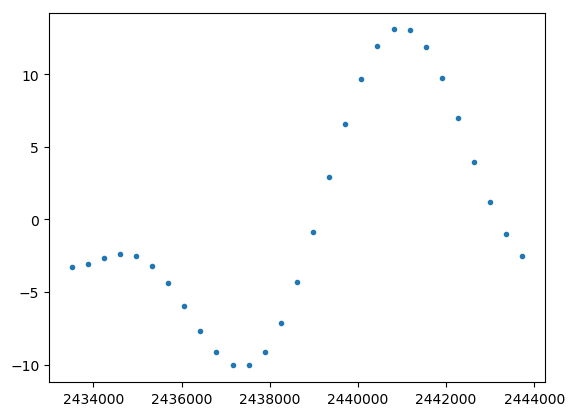

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f5a05c0>

In [13]:
plot(time1,ttv1.*3600*24,".")

## Reference angle

In [ ]:
f = extract_data("OUTPUTS/moon_fitmtry2params.jld2")

In [ ]:
@load("mcmc_mtryresults.jld2")

In [ ]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = f["pbest_global"]

In [ ]:
w1 = calc_deg(atan(e1sinw1,e1cosw1))
w2 = calc_deg(atan(e2sinw2,e2cosw2))
w3 = calc_deg(atan(e3sinw3,e3cosw3))
w1,w2,w3

In [ ]:
L_1 = calc_L(tt1,tt01,P_1,e1sinw1)
L_2 = calc_L(tt2,tt02,P_2,e2sinw2)
L_1,L_2

In [228]:
(((360/P1) .* (tt01 .- J2000)) .+ 181.97909950) 

49-element Array{Float64,1}:
 -27642.43014947823 
 -27282.430158204912
 -26922.43016693159 
 -26562.430175659018
 -26202.430184385696
 -25842.430193112374
 -25482.430201839055
 -25122.43021056648 
 -24762.43021929316 
 -24402.43022801984 
 -24042.43023674652 
 -23682.430245473945
 -23322.430254200626
      ⋮             
 -14322.430472371347
 -13962.430481098772
 -13602.430489825452
 -13242.430498552132
 -12882.430507278812
 -12522.430516006238
 -12162.430524732918
 -11802.430533459597
 -11442.430542186275
 -11082.430550913703
 -10722.430559640381
 -10362.430568367061

In [ ]:
((360/P_2) .* (tt02 .- J2000) .+ 100.46457166)

In [ ]:
[(360/P_3) .* (t03 .- J2000) .+ 34.39644051,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*1,
(360/P_3) .* (t03 .- J2000) .+ 34.39644051 + 360*2]

[Can't recall how i found this]

In [ ]:
77.56936298207381+w1,77.76976911511983+w2,77.91649744476126+w3

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,5]),vec(par_mcmc[:,iburn:nsteps,4]))) .+ 77.6
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e1sinw1,e1cosw1)) + 77.6
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 131.601125535
truey = 102.78555318000001
meanx=mean(xvalue);sigmax=std(xvalue)
meany=mean(yvalue);sigmay=std(yvalue)
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Venus [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
xvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,15]),vec(par_mcmc[:,iburn:nsteps,14]))) .+ 77.9
yvalue = calc_deg.(atan.(vec(par_mcmc[:,iburn:nsteps,10]),vec(par_mcmc[:,iburn:nsteps,9]))) .+ 77.8
optx = calc_deg(atan(e3sinw3,e3cosw3)) + 77.9
opty = calc_deg(atan(e2sinw2,e2cosw2)) + 77.8
truex = 14.62221649
truey = 102.78555318000001
nbins=50
corner_plot(xvalue,yvalue,nbins,optx,opty,truex,truey)
xlabel(L"Longitude $\varpi$ of Jupiter [$deg$]")
ylabel(L"Longitude $\varpi$ of Earth [$deg$]")

In [ ]:
(360/P_3 * (t03 - J2000) - 34.39644051)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),
0.815,-0.004,-0.002,224.5)

In [ ]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,14]),
    vec(par_mcmc[:,iburn:nsteps,15]),
    vec(par_mcmc[:,iburn:nsteps,12])
318,-0.004,-0.002,224.5)

## Testing